# Testing different methods for ground induction

This notebook will run Lompe with four different methods for testing ground induction:
- Plain: Using all components of the ground magnetic field and model the ground magnetic field as being produced exclusively by space currents (i.e., ignore induction)
- Only horizontal: Since we know that $B_r$ is more affected by induction, it may be a better idea to use only the horizontal components
- Mirror current with all components: Use the assumption that there is a superconducting layer in the Earth to model the induced currents. Even though it is simplistic, it is compelling because it is computationally straightforward. Hopefully it is also better than ignoring induction completely. 
- Mirror current with only horizontal components: Same as above, but only using horizontal components since we know induction effects in $B_r$ are more complicated.

I'll use the space hurricane event as an example

Model interval is 2001-08-17 16:27:14 UT to 2001-08-17 16:31:14 UT
grid lat, lon : 75.69322204589844 -31.540376663208008


/Users/laundal/Dropbox/git/lompe_repo/lompe/secsy/secsy/cubedsphere.py:202: RuntimeWarning: invalid value encountered in cos
  r = np.vstack((np.cos(lat) * np.cos(lon),
/Users/laundal/Dropbox/git/lompe_repo/lompe/secsy/secsy/cubedsphere.py:203: RuntimeWarning: invalid value encountered in cos
  np.cos(lat) * np.sin(lon),
/Users/laundal/Dropbox/git/lompe_repo/lompe/secsy/secsy/cubedsphere.py:203: RuntimeWarning: invalid value encountered in sin
  np.cos(lat) * np.sin(lon),
/Users/laundal/Dropbox/git/lompe_repo/lompe/secsy/secsy/cubedsphere.py:204: RuntimeWarning: invalid value encountered in sin
  np.sin(lat)))


NO INDUCTION ALL COMPONENTS


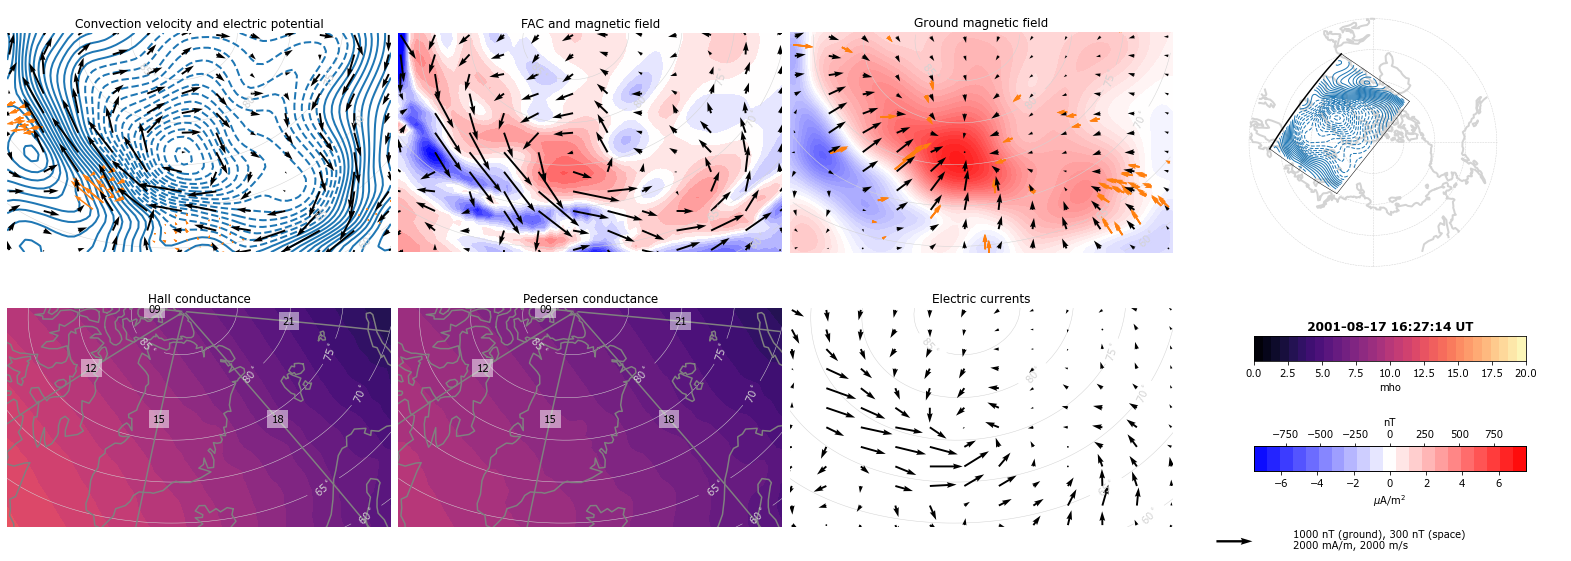

MIRROR CURRENT ALL COMPONENTS


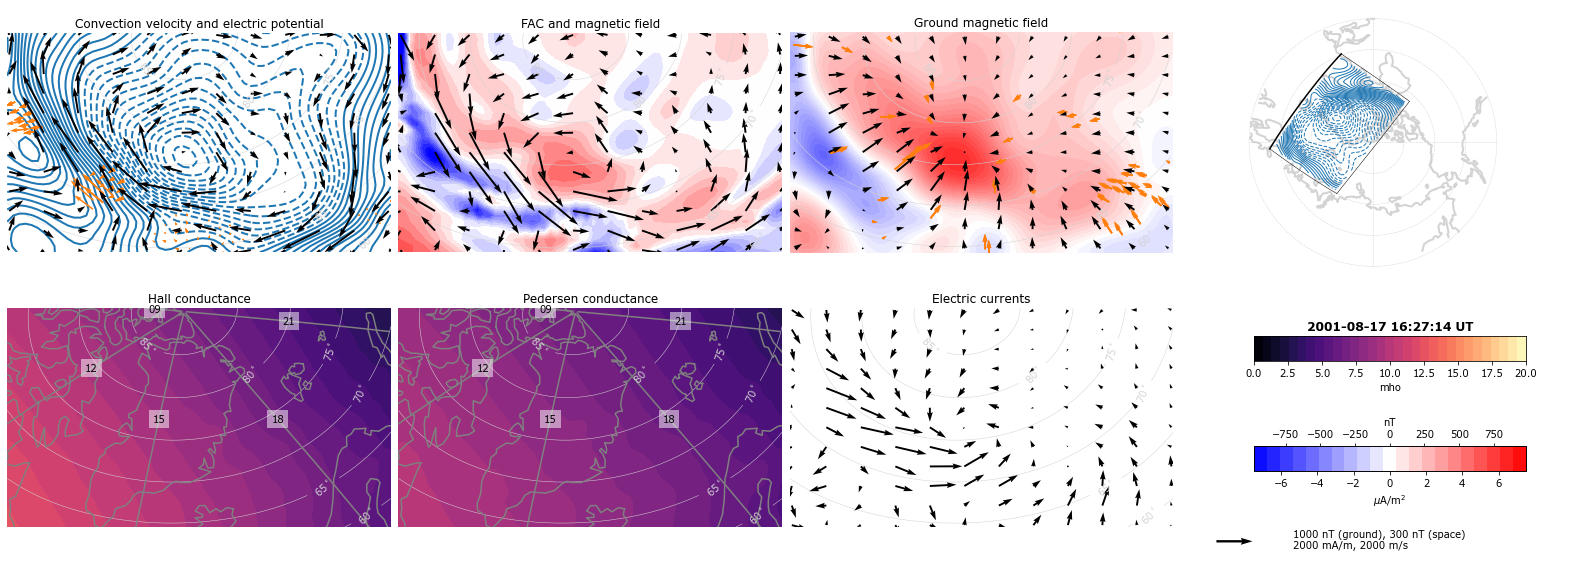

NO INDUCTION HORIZONTAL COMPONENTS


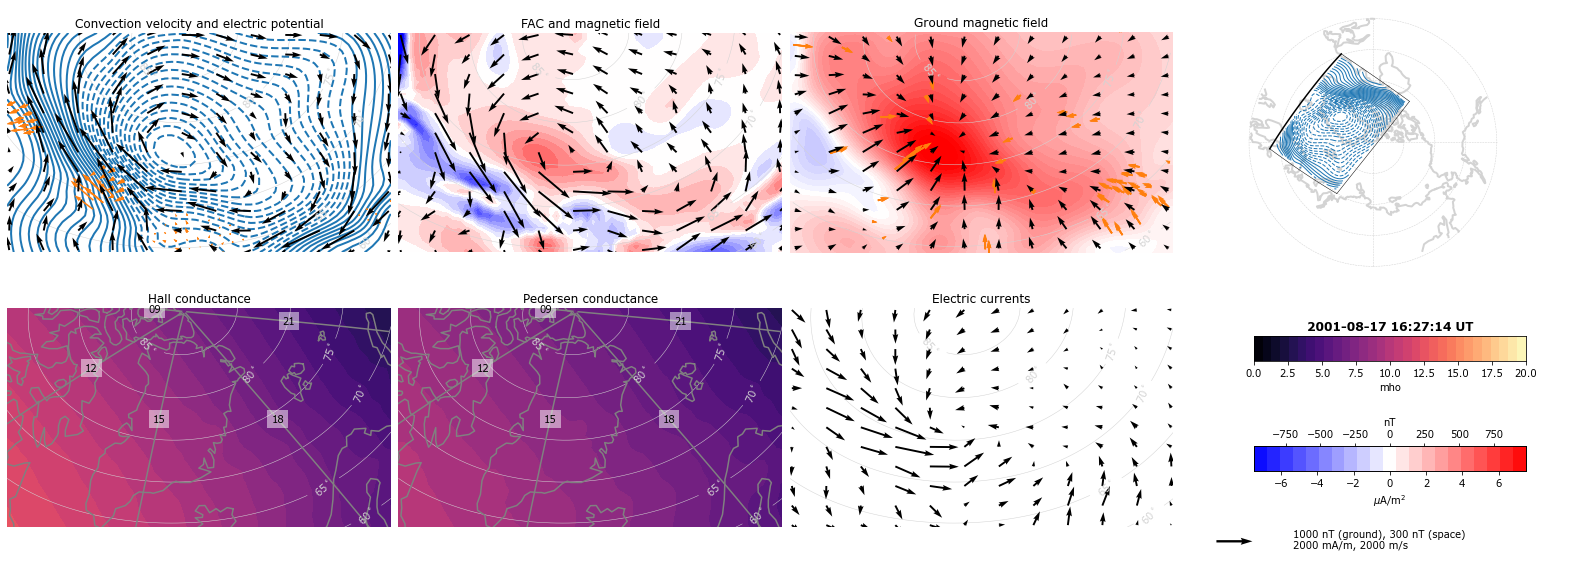

MIRROR CURRENTS HORIZONTAL COMPONENTS


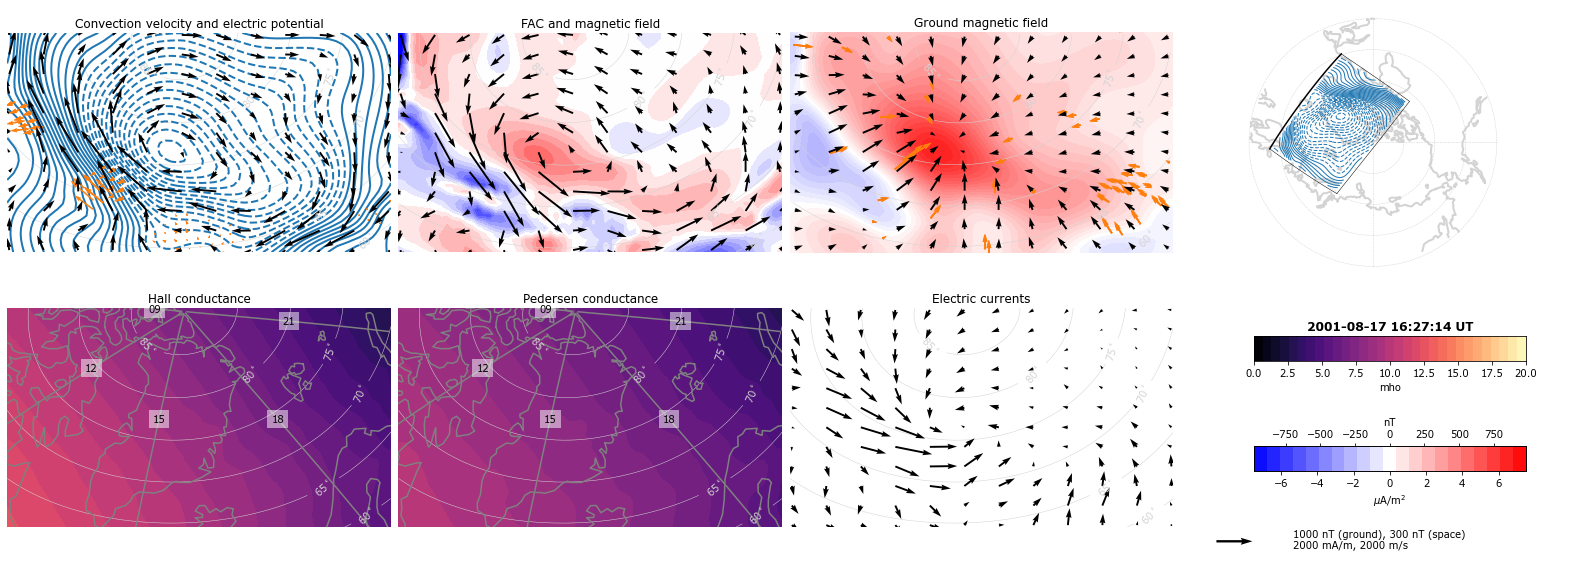

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import lompe
from apexpy import Apex
from scipy.interpolate import interp1d, griddata
from lompe.utils.geodesy import geoc2geod
from ppigrf import igrf_gc
from lompe.polplot import Polarplot
from lompe import visualization
from lompe.utils import sunlight
from lompe.utils.conductance import EUV_conductance
import cdflib # to read Champ data file

event = '2001-08-17'

wicfn = '../sample_dataset/20010817_wic_image.nc'
supermagfn = '../sample_dataset/20010817_supermag.h5'
champfn = '../sample_dataset/20010817_champ_magnetic_field.cdf'
sdarnfn = '../sample_dataset/20010817_superdarn_grdmap.h5'

# Conductances from IMAGE WIC:
ds = xr.open_dataset(wicfn)

EE  = np.array([0.2, 0.5, 1.0, 5.0, 10.0, 25.0])
E1  = np.array([446, 470, 511, 377, 223, 101])
fE1 = interp1d(EE, E1, fill_value = (446, 101), bounds_error = False)

assumed_mean_energy = 2.56 # keV
ds['eFlux'] = ds['shimage'] / fE1(assumed_mean_energy)
ds['eFlux'].attrs = {'long_name' : 'Energy flux', 'units' : '$mW/m^2$'}
ds['eFlux'] = ds['eFlux'].clip(0, None)      # set negatives to zero

# use Robinson formulae to calculate conductances
ds['SPedersen'] = 40 * assumed_mean_energy / (16 * assumed_mean_energy**2) * np.sqrt(ds['eFlux'])
ds['SHall'] = 0.45 * assumed_mean_energy ** 0.85 * ds['SPedersen']

DT = dt.timedelta(seconds = 60*4) # model a four minute time interval
date = pd.to_datetime(ds.date.values)

# model time interval
t0 = date - DT/2
t1 = date + DT/2
print('Model interval is ' + str(t0) + ' UT to ' + str(t1) + ' UT')


# grid specs
L, W, Lres, Wres = 6000.e3, 3000.e3, 75.e3, 75.e3 # dimensions and resolution of grid, in meters
pos = (0, 90)  # defualt center of cubed sphere grid
CENTER_IN_SPOT = True # will center grid in designated spot

# apex object for coordinate systems
a = Apex(date = date.year)

if CENTER_IN_SPOT:
    # find the geographic coordinate of the spot
    mlat = 78
    mlt  = 16.5

    mlon = a.mlt2mlon(mlt, date)
    glat, glon, error = a.apex2geo(mlat, mlon, 130)
    print('grid lat, lon :', glat, glon)
    pos = (glon, glat)
p = lompe.cs.CSprojection(pos, 20)

# image grid
imgrid = lompe.cs.CSgrid(p, L, W, Lres, Wres, R = (6371.2 + 110)*1e3)

lon, lat = ds.glon.values.flatten(), ds.glat.values.flatten()
SH_num = ds['SHall'    ].values.flatten()
SP_num = ds['SPedersen'].values.flatten()

iii = imgrid.ingrid(lon, lat, ext_factor = 1.3)

xi, eta = p.geo2cube(lon[iii], lat[iii])

# interpolate pixels to the grid:
SH_grd = griddata(np.vstack((xi, eta)).T, SH_num[iii], np.vstack((imgrid.xi.flatten(), imgrid.eta.flatten())).T).reshape(imgrid.shape)
SP_grd = griddata(np.vstack((xi, eta)).T, SH_num[iii], np.vstack((imgrid.xi.flatten(), imgrid.eta.flatten())).T).reshape(imgrid.shape)

# make a function that picks values from the right grid cell
def get_conductance(lon, lat, time, type = 'Hall'):
    shape = lon.shape
    if type == 'Hall':
        C = SH_grd
    if type == 'Pedersen':
        C = SP_grd

    sza = sunlight.sza(lat.flatten(), lon.flatten(), time)
    
    i, j = imgrid.bin_index(lon.flatten(), lat.flatten())
    conductance = np.sqrt(C[i, j].flatten()**2 + EUV_conductance(sza, 100, type[0].lower())**2)
    
    return conductance.reshape(shape)

# construct tuple of Hall / Pedersen functions to pass to lompe Emodel object:
conductances = (lambda lon, lat : get_conductance(lon, lat, t0, type = 'Hall'),
                lambda lon, lat : get_conductance(lon, lat, t0, type = 'Pedersen'))

grid = lompe.cs.CSgrid(p, L, W, Lres, Wres, R = (6371.2 + 110)*1e3)


# a modified version of the get_data_subsets function from the original notebook, now allowing for the
# choice of certain components in ground mags
def get_data_subsets(t0, t1, ground_B_components = np.arange(3)):
    """ return subsets of data loaded above, between t0 and t1 """

    # SuperMAG data:
    smag = supermag.loc[t0:t1, :]
    smag_B = np.vstack((smag.Be.values, smag.Bn.values, smag.Bu.values))[ground_B_components]
    smag_coords = np.vstack((smag.lon.values, smag.lat.values))
    
    # SuperDARN data:
    sd = superdarn # the file contains data only from the correct time interval, no time selection needed
    vlos = sd['v'].values     # this is median value in gridded obs.
    sd_coords = np.vstack((sd['glon'].values, sd['glat'].values))
    los  = np.vstack((sd['le'].values, sd['ln'].values))
    sd_err = sd['std']           # standard deviation as error
    
    # Make the data objects. The scale keyword determines a weight for the dataset. Increase it to reduce weight
    supermag_data  = lompe.Data(smag_B * 1e-9, smag_coords,            datatype = 'ground_mag', scale = 100e-9, components = ground_B_components)
    superdarn_data = lompe.Data(vlos         , sd_coords  , LOS = los, datatype = 'convection', scale = 500 )
    
    return supermag_data, superdarn_data

def superdarn_fix(superdarn):
    ''' Add geographic components to superDARN data set.'''
    
    SDmlat  = superdarn['mlat'].values
    SDmlon  = superdarn['mlon'].values
    bearing = superdarn['bearing'].values

    # convert to geographic coordinates
    SDglat, SDglon, _ = a.apex2geo(SDmlat, SDmlon, 110)
    
    # line-of-sight vector components, in magnetic AACGM
    le_m, ln_m = np.sin(bearing * np.pi / 180), np.cos(bearing * np.pi / 180)
    
    # find bearing angle in geographic
    f1, f2 = a.basevectors_qd(SDglat, SDglon, 110) # vectors pointing roughly east, north AACGM
    
    # normalize the northward vector, and define a new eastward vector that is perpendicular:
    f2 = f2 / np.linalg.norm(f2, axis = 0)
    f1 = np.cross(np.vstack((f2, np.zeros(f2.shape[1]))).T, np.array([[0, 0, 1]])).T[:2]
    
    # line of sight vector components in geographic
    le, ln = f1 * le_m + f2 * ln_m
    
    superdarn['glat'], superdarn['glon'] = SDglat, SDglon
    superdarn['le'], superdarn['ln'] = le, ln
    
    return superdarn



# set up the CHAMP plot


cdf = cdflib.CDF(champfn)
mag = cdf['NEC_VEC'] # space magnetometer data

# geocentric coords of CHAMP orbit
theta = 90 - cdf['GEO_LAT']
phi   = cdf['GEO_LON']
r     = cdf['GEO_ALT'] + 6371.2

time = cdflib.epochs.CDFepoch.to_datetime(cdf.varget('EPOCH')) 

# using IGRF to calculate magntic disturbance (dB) registered by CHAMP
Br, Btheta, Bphi = igrf_gc(r, theta, phi, time[0])
B0 = np.vstack((-Btheta.flatten(), Bphi.flatten(), -Br.flatten()))
dB = mag.T - B0

champ_df = pd.DataFrame({'Be':dB[1], 'Bn':dB[0], 'Br':-dB[2], 'lon':phi, 'lat':90 - theta, 'r':r*1e3}, index = time)['2001-08-17 16:25':'2001-08-17 16:35']

# convert CHAMP coords to geodetic
ch_gdlat, ch_h, ch_Bn, ch_Bz = geoc2geod(90 - champ_df['lat'], champ_df['r'] * 1e-3, -champ_df['Bn'], champ_df['Br'])



















# load data
superdarn = pd.read_hdf(sdarnfn)
supermag = pd.read_hdf(supermagfn)

# correct superdarn data
superdarn = superdarn_fix(superdarn)

# get correct time
supermag_data, superdarn_data = get_data_subsets(t0, t1)

model_no_induction = lompe.Emodel(grid, Hall_Pedersen_conductance = conductances)
model_mirror_current = lompe.Emodel(grid, Hall_Pedersen_conductance = conductances, perfect_conductor_radius = (6371.2 - 1000) * 1e3)
model_no_induction.add_data(supermag_data, superdarn_data)
model_mirror_current.add_data(supermag_data, superdarn_data)
model_no_induction.run_inversion(l1 = 1, l2 = 10)
model_mirror_current.run_inversion(l1 = 1, l2 = 10)

Be_no_induction, Bn_no_induction, Bu_no_induction = model_no_induction.B_space(champ_df['lon'].values, ch_gdlat, ch_h * 1e3 + 6371.2e3)
Be_mirror_current, Bn_mirror_current, Bu_mirror_current = model_mirror_current.B_space(champ_df['lon'].values, ch_gdlat, ch_h * 1e3 + 6371.2e3)



cscales = {'fac' : np.linspace(-5, 5, 22)*1e-6*1.5, 'ground_mag' : np.linspace(-980, 980, 50) * 1e-9}
quiverscales = {'electric_current' : 4000e-3, 'space_mag_fac'    : 2000e-9, 'convection'       : 4000, 'ground_mag'       : 2000e-9}
print('NO INDUCTION ALL COMPONENTS')
fig, axes_, _, __ = lompe.lompeplot(model_no_induction, include_data = True, apex = a, time = t0, colorscales = cscales, quiverscales = quiverscales, return_axes = True)
print('MIRROR CURRENT ALL COMPONENTS')
fig, axes_, _, __ = lompe.lompeplot(model_mirror_current, include_data = True, apex = a, time = t0, colorscales = cscales, quiverscales = quiverscales, return_axes = True)


supermag_data_horizontal, _ = get_data_subsets(t0, t1, ground_B_components = np.array([0, 1], dtype = np.int16))

model_no_induction.clear_model(Hall_Pedersen_conductance = conductances)
model_mirror_current.clear_model(Hall_Pedersen_conductance = conductances)
model_no_induction.add_data(supermag_data_horizontal, superdarn_data)
model_mirror_current.add_data(supermag_data_horizontal, superdarn_data)
model_no_induction.run_inversion(l1 = 1, l2 = 10)
model_mirror_current.run_inversion(l1 = 1, l2 = 10)
print('NO INDUCTION HORIZONTAL COMPONENTS')
fig, axes_, _, __ = lompe.lompeplot(model_no_induction, include_data = True, apex = a, time = t0, colorscales = cscales, quiverscales = quiverscales, return_axes = True)
print('MIRROR CURRENTS HORIZONTAL COMPONENTS')
fig, axes_, _, __ = lompe.lompeplot(model_mirror_current, include_data = True, apex = a, time = t0, colorscales = cscales, quiverscales = quiverscales, return_axes = True)

Be_no_induction_hor, Bn_no_induction_hor, Bu_no_induction_hor = model_no_induction.B_space(champ_df['lon'].values, ch_gdlat, ch_h * 1e3 + 6371.2e3)
Be_mirror_current_hor, Bn_mirror_current_hor, Bu_mirror_current_hor = model_mirror_current.B_space(champ_df['lon'].values, ch_gdlat, ch_h * 1e3 + 6371.2e3)



Now we repeat the plot of the CHAMP comparison to see how the four cases affect the predictions of the magnetic field in space.

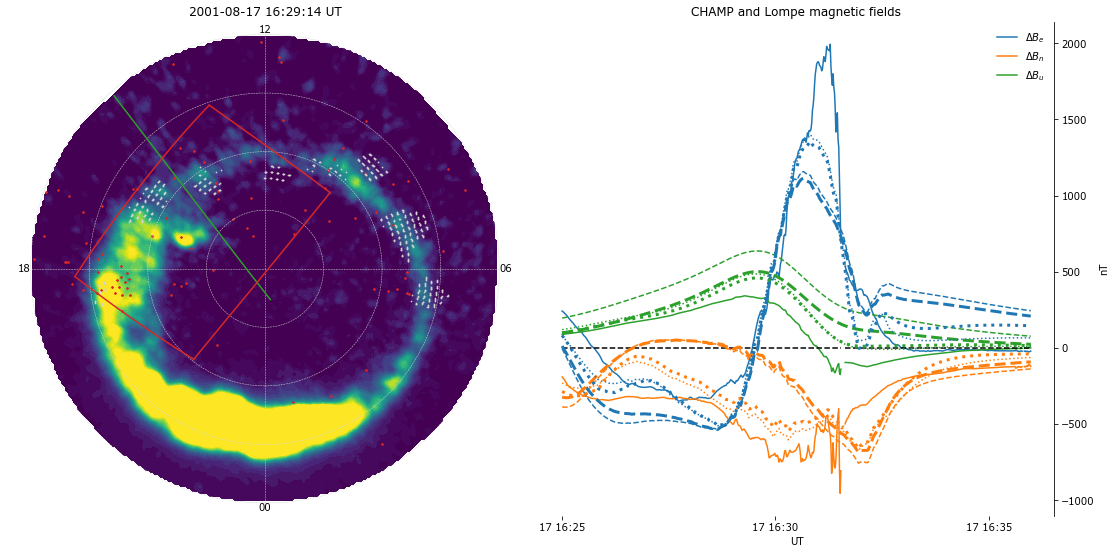

In [2]:

# plot comparing modelled dB to CHAMP measurements
fig, axes = plt.subplots(ncols = 2, figsize = (12*1.3, 6*1.3))

# Champ magnetic disturbance observations (east, north, up) in solid lines
# lompe magnetic disturbances along Champ trajectory (east, north, up) in dashed lines
axes[1].plot(champ_df.index, champ_df['Be'], color = 'C0', label = r'$\Delta B_e$')
axes[1].plot(champ_df.index, ch_Bn, color = 'C1', label = r'$\Delta B_n$')
axes[1].plot(champ_df.index, -ch_Bz, color = 'C2', label = r'$\Delta B_u$')

# axis labels and lines
axes[1].legend(frameon = False)
axes[1].yaxis.set_label_position("right")
axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')
axes[1].set_ylabel('nT')
axes[1].set_xlabel('UT')
axes[1].set_title('CHAMP and Lompe magnetic fields')
axes[1].plot(champ_df.index, ch_Bz*0, 'k--')
axes[1].yaxis.tick_right()

# add plot to show data coverage and CHAMP orbit
pax = Polarplot(axes[0])

x, y = pax._latlt2xy(ds['mlat'].values.flatten(), ds['mlt'].values.flatten())
xx, yy = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))

# plotting IMAGE WIC used for conductance
im = ds['shimage'].values.flatten()
iii = (x**2 + y**2) <= 1
image = griddata(np.vstack((x[iii], y[iii])).T, im[iii], np.vstack((xx.flatten(), yy.flatten())).T)
pax.ax.contourf(xx, yy, image.reshape((200, 200)), levels = np.linspace(0, 3000, 25), extend = 'both')

# plot CHAMP orbit as green line - but must convert to apex first
mlat, mlon = a.geo2apex(ch_gdlat, champ_df['lon'], ch_h)
mlt = np.array([a.mlon2mlt(ml, t) for ml, t in zip(mlon, champ_df.index.to_pydatetime())])
pax.plot(mlat, mlt, color = 'C2')

# plot lompe grid - but project to apex first
lats = [grid.lat[0, :], grid.lat[-1, :], grid.lat[:, 0], grid.lat[:, -1]]
lons = [grid.lon[0, :], grid.lon[-1, :], grid.lon[:, 0], grid.lon[:, -1]]
for lon, lat, in zip(lons, lats):
    mlat, mlon = a.geo2apex(lat, lon, 110)
    mlt = a.mlon2mlt(mlon, t0)
    pax.plot(mlat, mlt, color = 'C3')

# add SuperMAG sites in red
supermag  = pd.read_hdf(supermagfn) # reload to get all
coords = supermag[t0:t1][['lat', 'lon']]
mlat, mlon = a.geo2apex(coords.lat.values, coords.lon.values, 0)
mlt = a.mlon2mlt(mlon, t0)

iii = mlat > 50 # mask sites outside of plot
pax.scatter(mlat[iii], mlt[iii], marker = '.', c = 'C3', s = 4)

# add SuperDARN backscatter in grey
pax.scatter(superdarn['mlat'].values, superdarn['mlt'].values, marker = '.', c = 'lightgrey', s = 2)

# make title for aurora plot
pax.ax.set_title(str(pd.to_datetime(ds.date.values))+' UT')
pax.writeLTlabels(lat = 50)

axes[1].plot(champ_df.index, Be_no_induction_hor   * 1e9, color = 'C0', linestyle = '--')
axes[1].plot(champ_df.index, Bn_no_induction_hor   * 1e9, color = 'C1', linestyle = '--')
axes[1].plot(champ_df.index, Bu_no_induction_hor   * 1e9, color = 'C2', linestyle = '--')
axes[1].plot(champ_df.index, Be_mirror_current_hor * 1e9, color = 'C0', linestyle = '--', linewidth = 3)
axes[1].plot(champ_df.index, Bn_mirror_current_hor * 1e9, color = 'C1', linestyle = '--', linewidth = 3)
axes[1].plot(champ_df.index, Bu_mirror_current_hor * 1e9, color = 'C2', linestyle = '--', linewidth = 3)

axes[1].plot(champ_df.index, Be_no_induction   * 1e9, color = 'C0', linestyle = ':')
axes[1].plot(champ_df.index, Bn_no_induction   * 1e9, color = 'C1', linestyle = ':')
axes[1].plot(champ_df.index, Bu_no_induction   * 1e9, color = 'C2', linestyle = ':')
axes[1].plot(champ_df.index, Be_mirror_current * 1e9, color = 'C0', linestyle = ':', linewidth = 3)
axes[1].plot(champ_df.index, Bn_mirror_current * 1e9, color = 'C1', linestyle = ':', linewidth = 3)
axes[1].plot(champ_df.index, Bu_mirror_current * 1e9, color = 'C2', linestyle = ':', linewidth = 3)

plt.tight_layout()
